In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
from safetensors.torch import load_file
import pandas as pd
import os
from tqdm import tqdm 

versi_model = 6


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_dir = os.path.abspath('../results/v_' + str(versi_model))
if not os.path.exists(model_dir):
    raise ValueError(f"Directory {model_dir} does not exist. Please check the path.")

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained(model_dir)

# Load the model weights from the safetensors file
model_path = os.path.join(model_dir, 'model.safetensors')
state_dict = load_file(model_path)

# Initialize the model and load the state dict
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, state_dict=state_dict)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Move the input tensors to the appropriate device
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get the model's predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class
    predictions = torch.argmax(outputs.logits, dim=-1)
    
    # Map the predicted class to the actual label (assuming you have a mapping)
    label_mapping = {0: 'Tidak Puas', 1: 'Neutral', 2: 'Puas'}
    predicted_label = label_mapping[predictions.item()]
    
    return predicted_label


In [3]:
# get dataset
df = pd.read_csv('../Dataset/dataset_2.csv')
df.head()

,Ulasan,Label
0,not bad,Neutral
1,beli bintang bicara,Neutral
2,alas warna kuning luntur kaos kaki putih,Neutral
3,harga segini worth sih kesalahan cuman salah m...,Neutral
4,ukurannya sih kayanya pake sepatu adidas new b...,Neutral


In [4]:
# List untuk menampung hasil prediksi
predicted_labels = []

# Iterasi pada setiap baris data
for index, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Ulasan']
    predicted_label = predict(text)
    predicted_labels.append(predicted_label)

# Menambahkan hasil prediksi ke dataframe baru
df['Predicted_Label'] = predicted_labels

100%|██████████| 1154/1154 [00:14<00:00, 79.75it/s]


In [5]:
df['Predicted_Label'].value_counts()

Predicted_Label
Neutral       409
Puas          387
Tidak Puas    358
Name: count, dtype: int64

In [6]:
df['Label'].value_counts()

Label
Neutral       400
Puas          400
Tidak Puas    354
Name: count, dtype: int64

In [7]:
def buat_pie_chart(df, title, label_col='Label'):
    # Menghitung distribusi label
    label_counts = df[label_col].value_counts()

    # Menambahkan jumlah data ke label
    labels = [f'{label} ({count})' for label, count in zip(label_counts.index, label_counts)]

    # Membuat pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Membuat pie chart menjadi bulat
    plt.show()


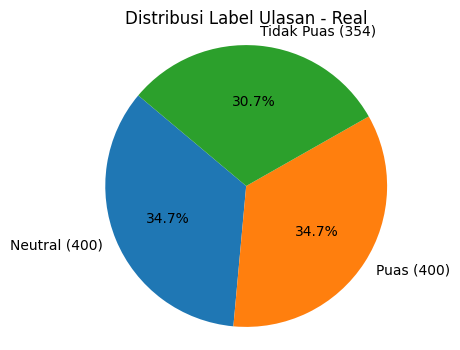

In [8]:

buat_pie_chart(df, 'Distribusi Label Ulasan - Real')

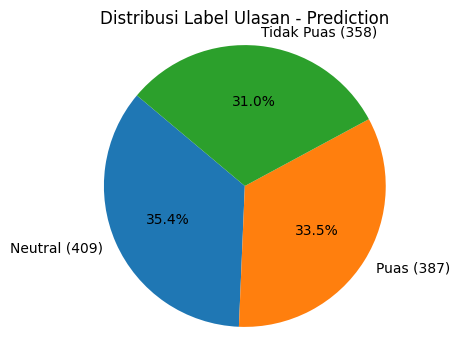

In [9]:

buat_pie_chart(df, 'Distribusi Label Ulasan - Prediction', 'Predicted_Label')

In [10]:
df

,Ulasan,Label,Predicted_Label
0,not bad,Neutral,Neutral
1,beli bintang bicara,Neutral,Neutral
2,alas warna kuning luntur kaos kaki putih,Neutral,Neutral
3,harga segini worth sih kesalahan cuman salah m...,Neutral,Tidak Puas
4,ukurannya sih kayanya pake sepatu adidas new b...,Neutral,Neutral
...,...,...,...
1149,sepatu belah kiri tekuk utk tumit,Tidak Puas,Neutral
1150,layan ratih listya buruk,Tidak Puas,Tidak Puas
1151,jelek barangnya,Tidak Puas,Tidak Puas
1152,kirim lamaa bangetttt,Tidak Puas,Tidak Puas


In [11]:
# Hitung akurasi
correct_predictions = (df['Predicted_Label'] == df['Label']).sum()
total_predictions = len(df)
accuracy = correct_predictions / total_predictions * 100
print(f'Correct predictions: {correct_predictions}/{total_predictions}')
print(f'Accuracy: {accuracy:.2f}%')

Correct predictions: 1107/1154
Accuracy: 95.93%


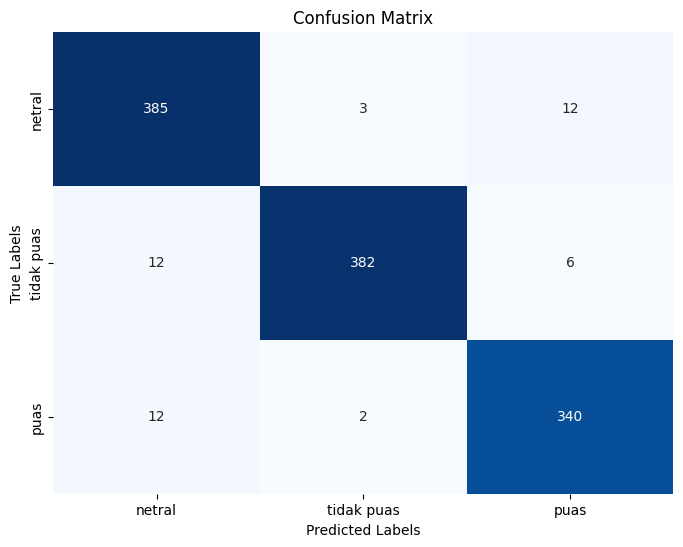

In [12]:
# Buat confusion matrix
conf_matrix = confusion_matrix(df['Label'], df['Predicted_Label'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['netral', 'tidak puas', 'puas'],
            yticklabels=['netral', 'tidak puas', 'puas'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()